# Imports

In [5]:
import numpy as np
# import qutip as qtp
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from qutip import *
from functools import cmp_to_key
from tqdm.notebook import tqdm
%matplotlib inline

# import sys
# import os
# current_dir = os.path.abspath(os.path.join('./ROfunctions.py'))
# sys.path.insert(0,current_dir)

import ROfunctions as ro
from ROfunctions import *

In [6]:
from functools import cmp_to_key
import pandas as pd
import cmath
from scipy import interpolate
from scipy.integrate import solve_ivp
from scipy.integrate import quad

#used in DispersiveShift.ipynb and ResonatorDynamics.ipynb

def truncate_disshift(hamiltonian, expectoperator):
    #sorts eigenvalues and eigenvectors to get the lowest dressed states
    evals, evecs = hamiltonian.eigenstates()
    evals_sort = np.argsort(evals)
    evals = evals[evals_sort]
    evecs = [evecs[i] for i in evals_sort]  # Ensure evecs remains a list of Qobj
    expvals = expect(expectoperator, evecs)
    expvals_index = np.argwhere(expvals < 1.2) #returns indices where expval is less than 1.1
    expvals_index_res0 = np.argwhere(expvals < 0.5)
    expvals_index_res1 = np.argwhere(expvals > 0.55)
    expvals_index_res0 = np.array([i for i in expvals_index if (i in expvals_index_res0)] )[:,0]
    expvals_index_res1 = np.array([i for i in expvals_index if (i in expvals_index_res1)] )[:,0]
    #identifies states of interest
    state0 = evecs[expvals_index_res0[0]] #qubit 0 resonator 0
    state1 = evecs[expvals_index_res1[0]] #qubit 0 resonator 1
    state2 = evecs[expvals_index_res0[1]] #qubit 1 resonator 0
    state3 = evecs[expvals_index_res1[1]] #qubit 1 resonator 1
    states = [state0, state1, state2, state3]
    #identifies energies of interest, q-qubit state, r-resonator state
    Eq0r0 = hamiltonian.matrix_element(state0.dag(), state0) #energies
    Eq1r0 = hamiltonian.matrix_element(state2.dag(), state2)
    Eq0r1 = hamiltonian.matrix_element(state1.dag(), state1)
    Eq1r1 = hamiltonian.matrix_element(state3.dag(), state3)
    energies = [Eq0r0, Eq0r1, Eq1r0, Eq1r1]
    #identifies frequencies needed in calculating dispersive shift
    qEdiff_r0 = Eq1r0 - Eq0r0
    qEdiff_r1 = Eq1r1 - Eq0r1
    rEdiff_q0 = Eq0r1 - Eq0r0
    rEdiff_q1 = Eq1r1 - Eq1r0
    frequencies = [qEdiff_r0, qEdiff_r1, rEdiff_q0, rEdiff_q1]
    
    chi_value = (rEdiff_q1 - rEdiff_q0) / 2
    #truncates Hamiltonian to smaller Hilbert space
    truncated_H  = Qobj([[hamiltonian.matrix_element(state0.dag(),state0), hamiltonian.matrix_element(state0.dag(),state1), hamiltonian.matrix_element(state0.dag(),state2), hamiltonian.matrix_element(state0.dag(),state3)],
                        [hamiltonian.matrix_element(state1.dag(),state0), hamiltonian.matrix_element(state1.dag(),state1), hamiltonian.matrix_element(state1.dag(),state2), hamiltonian.matrix_element(state1.dag(),state3)],
                        [hamiltonian.matrix_element(state2.dag(),state0), hamiltonian.matrix_element(state2.dag(),state1), hamiltonian.matrix_element(state2.dag(),state2), hamiltonian.matrix_element(state2.dag(),state3)],
                        [hamiltonian.matrix_element(state3.dag(),state0), hamiltonian.matrix_element(state3.dag(),state1), hamiltonian.matrix_element(state3.dag(),state2), hamiltonian.matrix_element(state3.dag(),state3)]])
    
    return states, energies, frequencies, chi_value, truncated_H

In [7]:
#states will take the form |qubit> tensor |resonator>
N = 30 #Hilbert space size for qubit
M = 5 #Hilbert space size for resonator

#ladder operators for qubit
c = destroy(N)
cdag = create(N)

#ladder operators for resonator
a = destroy(M)
adag = create(M)

#resonator number operator
rnum = adag * a
resonator_num = tensor(qeye(N), rnum)

#energy parameters
w = 7.0 #resonator frequency (GHz)

Ej = 4 #Josephson energy of qubit (GHz)
Ec = 0.5 #capacitive energy of qubit (GHz)
El = 0.1 #inductive energy of qubit (GHz)

g = 0.05 #coupling strength (GHz)

#Hamiltonian terms
H_lc = w * (adag * a + 1/2) #resonator/LC oscillator term

coupling1 = tensor(c, adag)
coupling2 = tensor(cdag, a)
H_i = g * (coupling1 + coupling2) #interaction term

phi_naught = ((8 * Ec) / El)**(1/4) #oscillator length
n_op = (-1j / (math.sqrt(2) * phi_naught)) * (c - cdag) #charge operator
phi_op = (phi_naught / math.sqrt(2)) * (c + cdag) #flux operator
phi_op_HC = phi_op.dag() #Hermitian conjugate of flux operator

Cterm = 4 * Ec * (n_op)**2
Lterm = (1/2) * El * phi_op**2

#Flux related
mfq = 2 * np.pi #magnetic flux quantum
phi_ext = np.linspace(0, mfq, 1001)

In [3]:
#states will take the form |qubit> tensor |resonator>
N = 30 #Hilbert space size for qubit
M = 5 #Hilbert space size for resonator

#ladder operators for qubit
c = destroy(N)
cdag = create(N)

#ladder operators for resonator
a = destroy(M)
adag = create(M)

#resonator number operator
rnum = adag * a
resonator_num = tensor(qeye(N), rnum)

#energy parameters
w = 6.0 #resonator frequency (GHz)

Ej = 3.5 #Josephson energy of qubit (GHz)
Ec = 0.5 #capacitive energy of qubit (GHz)
El = 0.1 #inductive energy of qubit (GHz)

g = 0.05 #coupling strength (GHz)

#Hamiltonian terms
H_lc = w * (adag * a + 1/2) #resonator/LC oscillator term

coupling1 = tensor(c, adag)
coupling2 = tensor(cdag, a)
H_i = g * (coupling1 + coupling2) #interaction term

phi_naught = ((8 * Ec) / El)**(1/4) #oscillator length
n_op = (-1j / (math.sqrt(2) * phi_naught)) * (c - cdag) #charge operator
phi_op = (phi_naught / math.sqrt(2)) * (c + cdag) #flux operator
phi_op_HC = phi_op.dag() #Hermitian conjugate of flux operator

Cterm = 4 * Ec * (n_op)**2
Lterm = (1/2) * El * phi_op**2

#Flux related
mfq = 2 * np.pi #magnetic flux quantum
phi_ext = np.linspace(0, mfq, 1001)

In [8]:
qubitEdiff_r0 = []
qubitEdiff_r1 = []
resEdiff_q0 = []
resEdiff_q1 = []
chi = [] #MHz

#loop over external flux
for phi in phi_ext:
    Jterm = -Ej * ((1/2) * ((1j * (phi_op - phi)).expm()) + (1/2) * ((-1j * (phi_op_HC - phi)).expm()))
    H_flux = Jterm + Cterm + Lterm
    H_sys = tensor(H_flux, qeye(M)) + tensor(qeye(N), H_lc) + H_i
    states, energies, frequencies, chi_value, truncated_H = truncate_disshift(H_sys, resonator_num)
    qubitEdiff_r0.append(frequencies[0].real)
    qubitEdiff_r1.append(frequencies[1].real)
    resEdiff_q0.append(frequencies[2].real)
    resEdiff_q1.append(frequencies[3].real)
    chi.append(chi_value.real * 1000)

In [9]:
qubitEdiff_r0 = []
qubitEdiff_r1 = []
resEdiff_q0 = []
resEdiff_q1 = []
chi = [] #MHz

#loop over external flux
for phi in phi_ext:
    Jterm = -Ej * ((1/2) * ((1j * (phi_op - phi)).expm()) + (1/2) * ((-1j * (phi_op_HC - phi)).expm()))
    H_flux = Jterm + Cterm + Lterm
    H_sys = tensor(H_flux, qeye(M)) + tensor(qeye(N), H_lc) + H_i
    states, energies, frequencies, chi_value, truncated_H = truncate_disshift(H_sys, resonator_num)
    qubitEdiff_r0.append(frequencies[0].real)
    qubitEdiff_r1.append(frequencies[1].real)
    resEdiff_q0.append(frequencies[2].real)
    resEdiff_q1.append(frequencies[3].real)
    chi.append(chi_value.real * 1000)

Text(0, 0.5, 'Dispersive Shift, $\\chi/2\\pi$ (MHz)')

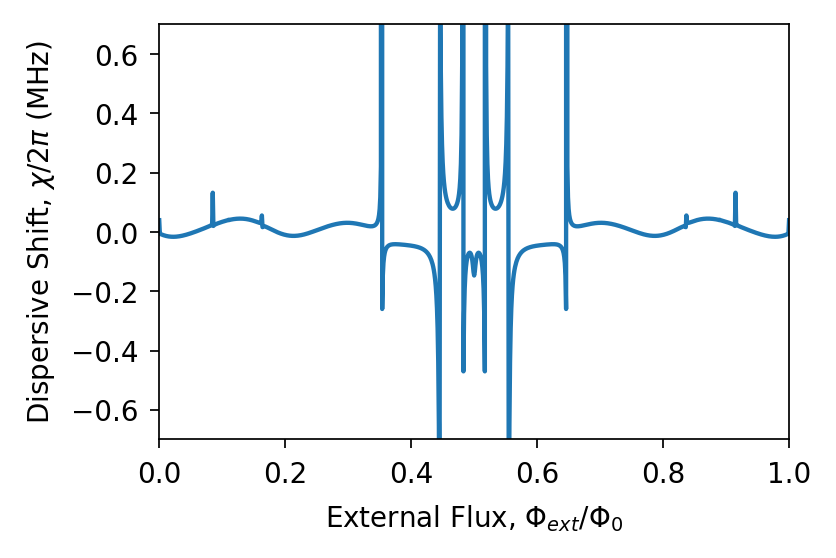

In [18]:
#1D plot of dispersive shift vs external flux
fig, ax = plt.subplots(ncols=1, nrows=1, dpi=250)

fig.subplots_adjust(bottom = 0.16, top=0.99, left=0.16, right=0.9, wspace=0.4, hspace=0.4)

fig.set_size_inches(3.40457, 2.0)
font = {'size' : 8}
mpl.rc('font', **font)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)
ax.tick_params(width=0.5, which='both')
ax.tick_params(length=2.5, which='major')
ax.tick_params(length=1.5, which='minor')

ax.plot(phi_ext / mfq, np.array(chi), linewidth=1.25)

ax.set_xlim(0, 1)
ax.set_ylim(-.7,.7)

ax.set_xlabel(r"External Flux, $\Phi_{ext}/\Phi_0$")
ax.set_ylabel(r"Dispersive Shift, $\chi/2\pi$ (MHz)")


Text(0, 0.5, 'Qubit Frequency, $\\omega_{10}/2\\pi$ (MHz)')

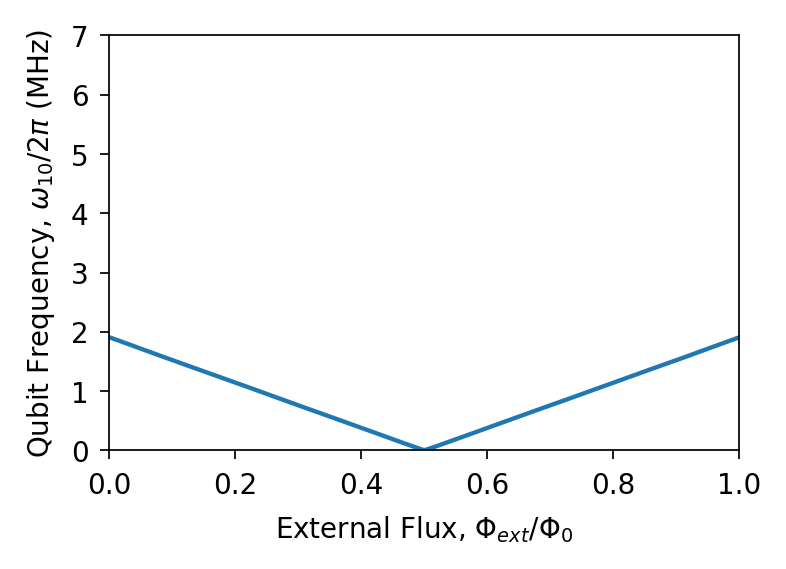

In [16]:
#1D plot of qubit frequency vs external flux
fig, ax = plt.subplots(ncols=1, nrows=1, dpi=250)

fig.subplots_adjust(bottom = 0.16, top=0.99, left=0.16, right=0.9, wspace=0.4, hspace=0.4)

fig.set_size_inches(3.40457, 2.0)
font = {'size' : 8}
mpl.rc('font', **font)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)
ax.tick_params(width=0.5, which='both')
ax.tick_params(length=2.5, which='major')
ax.tick_params(length=1.5, which='minor')

ax.plot(phi_ext / mfq, np.array(qubitEdiff_r0), linewidth=1.25)

ax.set_xlim(0, 1)
ax.set_ylim(0,7)

ax.set_xlabel(r"External Flux, $\Phi_{ext}/\Phi_0$")
ax.set_ylabel(r"Qubit Frequency, $\omega_{10}/2\pi$ (MHz)")

Text(0, 0.5, 'Qubit Frequency, $\\omega_{10}/2\\pi$ (MHz)')

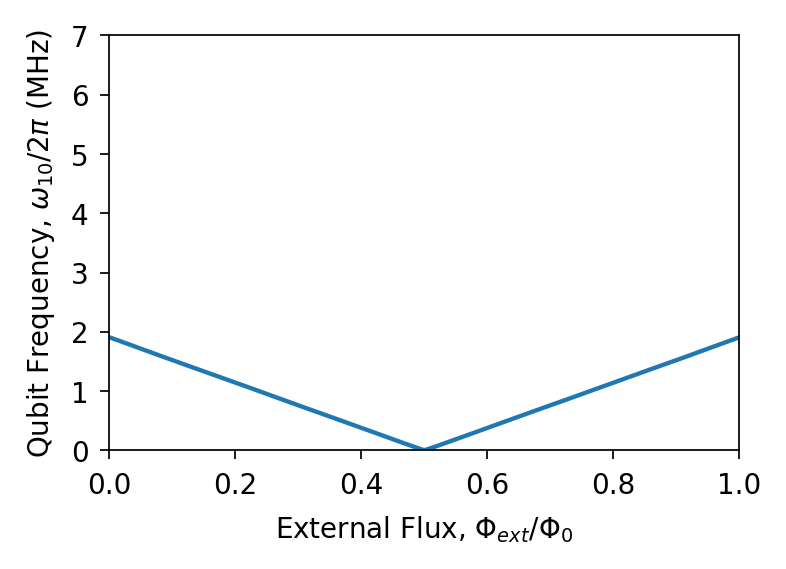

In [15]:
#1D plot of qubit frequency vs external flux
fig, ax = plt.subplots(ncols=1, nrows=1, dpi=250)

fig.subplots_adjust(bottom = 0.16, top=0.99, left=0.16, right=0.9, wspace=0.4, hspace=0.4)

fig.set_size_inches(3.40457, 2.0)
font = {'size' : 8}
mpl.rc('font', **font)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)
ax.tick_params(width=0.5, which='both')
ax.tick_params(length=2.5, which='major')
ax.tick_params(length=1.5, which='minor')

ax.plot(phi_ext / mfq, np.array(qubitEdiff_r0), linewidth=1.25)

ax.set_xlim(0, 1)
ax.set_ylim(0,7)

ax.set_xlabel(r"External Flux, $\Phi_{ext}/\Phi_0$")
ax.set_ylabel(r"Qubit Frequency, $\omega_{10}/2\pi$ (MHz)")

# 2D maps to see energy dependence

In [7]:
Ec = 1
Ej = 8

Eind = np.linspace(0.05, 0.5, 101)
phi_ext = np.linspace(0, mfq, 101)

chi = np.zeros((len(Eind), len(phi_ext)))
qubitEdiff_r0 = np.zeros((len(Eind), len(phi_ext)))

for n, phi in enumerate(tqdm(phi_ext, desc = "phi_ext loop")):
    for m, l in enumerate(tqdm(Eind, desc = "El loop")):
        phi_naught = ((8 * Ec) / l)**(1/4)
        n_op = (-1j / (math.sqrt(2) * phi_naught)) * (c - cdag)
        phi_op = (phi_naught / math.sqrt(2)) * (c + cdag)
        phi_op_HC = phi_op.dag()
        Cterm = 4 * Ec * (n_op)**2
        Lterm = (1/2) * l * phi_op**2
        Jterm = -Ej * ((1/2) * ((1j * (phi_op - phi)).expm()) + (1/2) * ((-1j * (phi_op_HC - phi)).expm()))
        H_flux = Jterm + Cterm + Lterm
        H_sys = tensor(H_flux, qeye(M)) + tensor(qeye(N), H_lc) + H_i
        states, energies, frequencies, chi_value, truncated_H = truncate_disshift(H_sys, resonator_num)
        chi[m][n] = chi_value.real * 1000 #MHz
        qubitEdiff_r0[m][n] = frequencies[0].real

phi_ext loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

In [6]:
Ec = 1
Ej = 8

Eind = np.linspace(0.05, 0.5, 101)
phi_ext = np.linspace(0, mfq, 101)

chi = np.zeros((len(Eind), len(phi_ext)))
qubitEdiff_r0 = np.zeros((len(Eind), len(phi_ext)))

for n, phi in enumerate(tqdm(phi_ext, desc = "phi_ext loop")):
    for m, l in enumerate(tqdm(Eind, desc = "El loop")):
        phi_naught = ((8 * Ec) / l)**(1/4)
        n_op = (-1j / (math.sqrt(2) * phi_naught)) * (c - cdag)
        phi_op = (phi_naught / math.sqrt(2)) * (c + cdag)
        phi_op_HC = phi_op.dag()
        Cterm = 4 * Ec * (n_op)**2
        Lterm = (1/2) * l * phi_op**2
        Jterm = -Ej * ((1/2) * ((1j * (phi_op - phi)).expm()) + (1/2) * ((-1j * (phi_op_HC - phi)).expm()))
        H_flux = Jterm + Cterm + Lterm
        H_sys = tensor(H_flux, qeye(M)) + tensor(qeye(N), H_lc) + H_i
        states, energies, frequencies, chi_value, truncated_H = truncate_disshift(H_sys, resonator_num)
        chi[m][n] = chi_value.real * 1000 #MHz
        qubitEdiff_r0[m][n] = frequencies[0].real

phi_ext loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class 'qutip.core.qobj.Qobj'>
    evecs[0].type: ket, evecs[0].shape: (150, 1)
--------------------
--------------------
Debugging truncate_disshift:
Type of expectoperator: <class 'qutip.core.qobj.Qobj'>
  expectoperator.type: oper, expectoperator.shape: (150, 150)
Type of evecs: <class 'numpy.ndarray'>
  evecs.ndim: 1
  evecs.shape: (150,)
  Type of evecs[0]: <class

KeyboardInterrupt: 

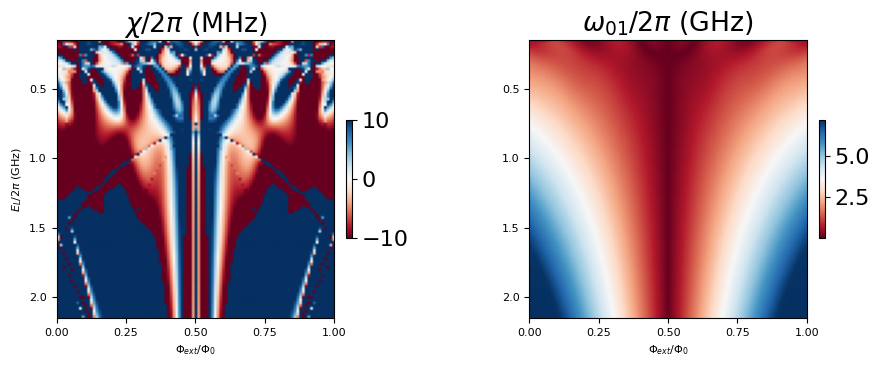

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,12))
fig.subplots_adjust(bottom = 0.16, top=0.99, left=0.16, right=0.8, wspace=0.6)
font = {'size' : 16}
plt.rc('font', **font)

im1 = ax1.imshow(chi, extent=[0,1,2.15,0.15], vmin=-10, vmax=10, cmap=plt.cm.RdBu)
ax1.set_title(r"$\chi/2\pi$ (MHz)")
fig.colorbar(im1, ax=ax1,fraction=0.02, pad=0.04)
ax1.set_xlabel(r"$\Phi_{ext}/\Phi_{0}$")
ax1.set_ylabel(r"$E_{L}/2\pi$ (GHz)")
ax1.set_aspect(0.5)

im2 = ax2.imshow(qubitEdiff_r0, extent=[0,1,2.15,0.15], cmap=plt.cm.RdBu)
ax2.set_title(r"$\omega_{01}/2\pi$ (GHz)")
fig.colorbar(im2, ax=ax2,fraction=0.02, pad=0.04)
ax2.set_xlabel(r"$\Phi_{ext}/\Phi_{0}$")
ax2.set_aspect(0.5)
plt.show()

### Constant $E_{J}$/$E_{C}$ (=5), and $E_{L}$, and loop over $E_{J}$ and $E_{C}$

In [13]:
El = 0.5

ratio = 5
Ej = np.linspace(2.5, 7.5, 101)
phi_ext = np.linspace(0, mfq, 101)

chi = np.zeros((len(Ej), len(phi_ext)))
qubitEdiff_r0 = np.zeros((len(Ej), len(phi_ext)))

for n, phi in enumerate(tqdm(phi_ext, desc = "phi_ext loop")):
    for m, j in enumerate(tqdm(Ej, desc = "Ej loop")):
        phi_naught = ((8 * (j/ratio)) / El)**(1/4)
        n_op = (-1j / (math.sqrt(2) * phi_naught)) * (c - cdag)
        phi_op = (phi_naught / math.sqrt(2)) * (c + cdag)
        phi_op_HC = phi_op.dag() 
        Cterm = 4 * (j/ratio) * (n_op)**2
        Lterm = (1/2) * El * phi_op**2   
        Jterm = -j * ((1/2) * ((1j * (phi_op - phi)).expm()) + (1/2) * ((-1j * (phi_op_HC - phi)).expm()))
        H_flux = Jterm + Cterm + Lterm
        H_sys = tensor(H_flux, qeye(M)) + tensor(qeye(N), H_lc) + H_i
        states, energies, frequencies, chi_value, truncated_H = truncate_disshift(H_sys, resonator_num)
        chi[m][n] = chi_value.real * 1000 #MHz
        qubitEdiff_r0[m][n] = frequencies[0].real

phi_ext loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

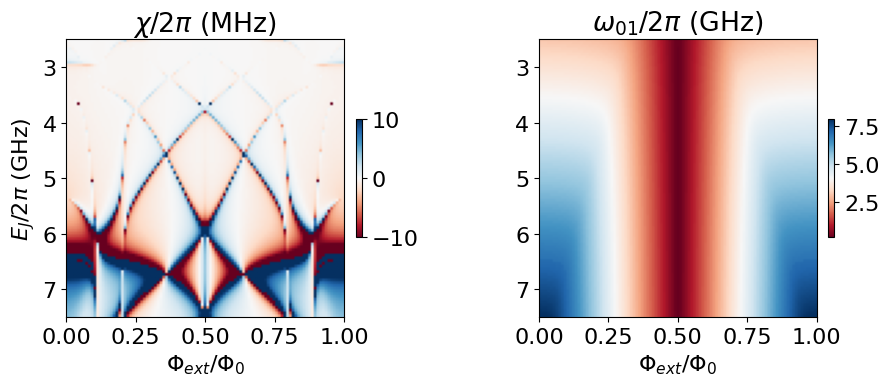

In [14]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,12))
fig.subplots_adjust(bottom = 0.16, top=0.99, left=0.16, right=0.8, wspace=0.6)
font = {'size' : 16}
plt.rc('font', **font)

im00 = ax[0].imshow(chi, extent=[0,1,7.5,2.5], vmin=-10, vmax=10, cmap=plt.cm.RdBu)
ax[0].set_title(r"$\chi/2\pi$ (MHz)")
fig.colorbar(im00, ax=ax[0],fraction=0.02, pad=0.04)
ax[0].set_xlabel(r"$\Phi_{ext}/\Phi_{0}$")
ax[0].set_ylabel(r"$E_{J}/2\pi$ (GHz)")
ax[0].set_aspect(0.2)

im01 = ax[1].imshow(qubitEdiff_r0, extent=[0,1,7.5,2.5], cmap=plt.cm.RdBu)
ax[1].set_title(r"$\omega_{01}/2\pi$ (GHz)")
fig.colorbar(im01, ax=ax[1],fraction=0.02, pad=0.04)
ax[1].set_xlabel(r"$\Phi_{ext}/\Phi_{0}$")
ax[1].set_aspect(0.2)

plt.show()

### Constant $E_{J}$ and $E_{L}$, and loop over $E_{C}$

In [15]:
El = 0.75
Ej = 8

Ec = np.linspace(0.2, 1.0, 101)
phi_ext = np.linspace(0, mfq, 101)

chi = np.zeros((len(Ec), len(phi_ext)))
qubitEdiff_r0 = np.zeros((len(Ec), len(phi_ext)))

for n, phi in enumerate(tqdm(phi_ext, desc = "phi_ext loop")):
    for m, b in enumerate(tqdm(Ec, desc = "Ec loop")):
        phi_naught = ((8 * b) / El)**(1/4)
        n_op = (-1j / (math.sqrt(2) * phi_naught)) * (c - cdag)
        phi_op = (phi_naught / math.sqrt(2)) * (c + cdag)
        phi_op_HC = phi_op.dag()
        Cterm = 4 * b * (n_op)**2
        Lterm = (1/2) * El * phi_op**2
        Jterm = -Ej * ((1/2) * ((1j * (phi_op - phi)).expm()) + (1/2) * ((-1j * (phi_op_HC - phi)).expm()))
        H_flux = Jterm + Cterm + Lterm
        H_sys = tensor(H_flux, qeye(M)) + tensor(qeye(N), H_lc) + H_i
        states, energies, frequencies, chi_value, truncated_H = truncate_disshift(H_sys, resonator_num)
        chi[m][n] = chi_value.real * 1000 #MHz
        qubitEdiff_r0[m][n] = frequencies[0].real

phi_ext loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

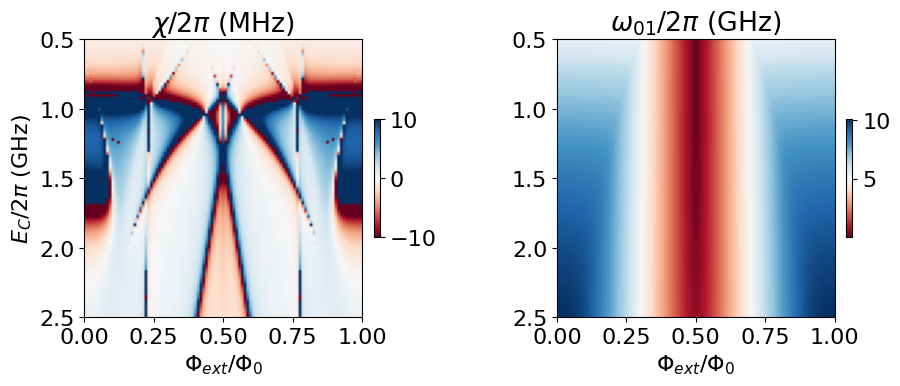

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,12))
fig.subplots_adjust(bottom = 0.16, top=0.99, left=0.16, right=0.8, wspace=0.6)
font = {'size' : 16}
plt.rc('font', **font)

im1 = ax1.imshow(chi, extent=[0,1,2.5,0.5], vmin=-10, vmax=10, cmap=plt.cm.RdBu)
ax1.set_title(r"$\chi/2\pi$ (MHz)")
fig.colorbar(im1, ax=ax1,fraction=0.02, pad=0.04)
ax1.set_xlabel(r"$\Phi_{ext}/\Phi_{0}$")
ax1.set_ylabel(r"$E_{C}/2\pi$ (GHz)")
ax1.set_aspect(0.5)

im2 = ax2.imshow(qubitEdiff_r0, extent=[0,1,2.5,0.5], cmap=plt.cm.RdBu)
ax2.set_title(r"$\omega_{01}/2\pi$ (GHz)")
fig.colorbar(im2, ax=ax2,fraction=0.02, pad=0.04)
ax2.set_xlabel(r"$\Phi_{ext}/\Phi_{0}$")
ax2.set_aspect(0.5)

plt.show()

### Constant $E_{C}$ and $E_{L}$, and loop over $E_{J}$

In [17]:
Ec = 0.75
El = 0.5

Ej = np.linspace(2.0, 8.0, 101)
phi_ext = np.linspace(0, mfq, 101)

chi = np.zeros((len(Ej), len(phi_ext)))
qubitEdiff_r0 = np.zeros((len(Ej), len(phi_ext)))

for n, phi in enumerate(tqdm(phi_ext, desc = "phi_ext loop")):
    for m, j in enumerate(tqdm(Ej, desc = "Ej loop")):
        phi_naught = ((8 * Ec) / El)**(1/4)
        n_op = (-1j / (math.sqrt(2) * phi_naught)) * (c - cdag)
        phi_op = (phi_naught / math.sqrt(2)) * (c + cdag)
        phi_op_HC = phi_op.dag()
        Cterm = 4 * Ec * (n_op)**2
        Lterm = (1/2) * El * phi_op**2
        Jterm = -j * ((1/2) * ((1j * (phi_op - phi)).expm()) + (1/2) * ((-1j * (phi_op_HC - phi)).expm()))
        H_flux = Jterm + Cterm + Lterm
        H_sys = tensor(H_flux, qeye(M)) + tensor(qeye(N), H_lc) + H_i
        states, energies, frequencies, chi_value, truncated_H = truncate_disshift(H_sys, resonator_num)
        chi[m][n] = chi_value.real * 1000 #MHz
        qubitEdiff_r0[m][n] = frequencies[0].real

phi_ext loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

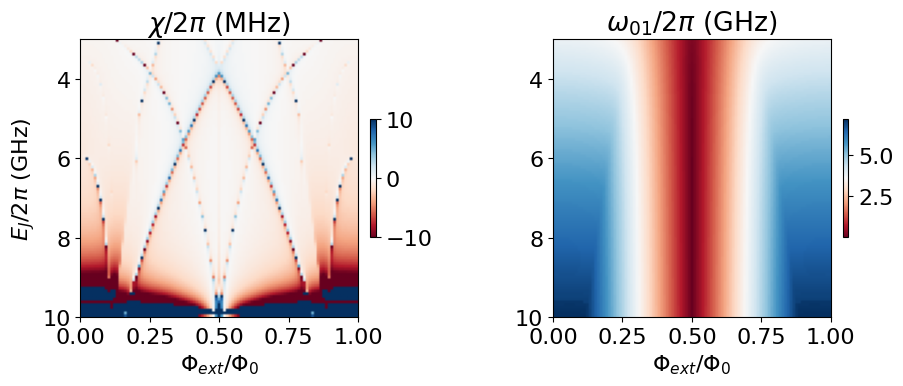

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,12))
fig.subplots_adjust(bottom = 0.16, top=0.99, left=0.16, right=0.8, wspace=0.6)
font = {'size' : 16}
plt.rc('font', **font)

im1 = ax1.imshow(chi, extent=[0,1,10,3], vmin=-10, vmax=10, cmap=plt.cm.RdBu)
ax1.set_title(r"$\chi/2\pi$ (MHz)")
fig.colorbar(im1, ax=ax1,fraction=0.02, pad=0.04)
ax1.set_xlabel(r"$\Phi_{ext}/\Phi_{0}$")
ax1.set_ylabel(r"$E_{J}/2\pi$ (GHz)")
ax1.set_aspect(1/7)

im2 = ax2.imshow(qubitEdiff_r0, extent=[0,1,10,3], cmap=plt.cm.RdBu)
ax2.set_title(r"$\omega_{01}/2\pi$ (GHz)")
fig.colorbar(im2, ax=ax2,fraction=0.02, pad=0.04)
ax2.set_xlabel(r"$\Phi_{ext}/\Phi_{0}$")
ax2.set_aspect(1/7)
plt.show()

In [19]:
# transition analysis
def analyze_transitions(H_sys, resonator_num):
    """Analyze transition matrix elements and energy differences"""
    states, energies, frequencies, chi_value, truncated_H = truncate_disshift(H_sys, resonator_num)
    
    # Calculate additional transition properties
    trans_matrix = []
    for i in range(len(states)):
        row = []
        for j in range(len(states)):
            element = abs(H_sys.matrix_element(states[i].dag(), states[j]))**2
            row.append(element)
        trans_matrix.append(row)
    
    return {
        'chi': chi_value,
        'transitions': np.array(trans_matrix),
        'energy_differences': frequencies
    }

# Use in parameter sweeps:
transitions_data = []
for n, phi in enumerate(tqdm(phi_ext, desc="phi_ext loop")):
    row_data = []
    for m, l in enumerate(tqdm(Eind, desc="El loop")):
        # ... [existing Hamiltonian setup] ...
        analysis = analyze_transitions(H_sys, resonator_num)
        row_data.append(analysis)
    transitions_data.append(row_data)

phi_ext loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

El loop:   0%|          | 0/101 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# visualization for transition strengths

def plot_transition_strength(transitions_data, phi_ext, param_range, param_name):
    """Plot transition strength map"""
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    # Extract transition strengths for specific states
    trans_01 = np.array([[d['transitions'][0,1] for d in row] for row in transitions_data])
    trans_12 = np.array([[d['transitions'][1,2] for d in row] for row in transitions_data])
    
    im1 = ax[0].imshow(trans_01, extent=[0,1,param_range[-1],param_range[0]], 
                       aspect='auto', cmap='viridis')
    ax[0].set_title('0->1 Transition Strength')
    ax[0].set_xlabel(r'$\Phi_{ext}/\Phi_0$')
    ax[0].set_ylabel(f'{param_name}/2π (GHz)')
    plt.colorbar(im1, ax=ax[0])
    
    im2 = ax[1].imshow(trans_12, extent=[0,1,param_range[-1],param_range[0]], 
                       aspect='auto', cmap='viridis')
    ax[1].set_title('1->2 Transition Strength')
    ax[1].set_xlabel(r'$\Phi_{ext}/\Phi_0$')
    plt.colorbar(im2, ax=ax[1])
    
    plt.tight_layout()
    plt.show()

In [ ]:
# sweet spot analysis
def analyze_sweet_spot(chi_array, frequencies, phi_ext):
    """Analyze width and properties of sweet spot"""
    
    # Find sweet spot location
    chi_at_half = np.abs(chi_array)/2
    sweet_spot_width = np.sum(chi_at_half < np.max(chi_at_half)/2) * (phi_ext[1]-phi_ext[0])
    
    # Calculate frequency spread
    freq_spread = np.max(frequencies) - np.min(frequencies)
    
    return {
        'sweet_spot_width': sweet_spot_width,
        'frequency_spread': freq_spread,
        'max_chi': np.max(np.abs(chi_array))
    }